In [1]:
import cv2
import numpy as np
import pandas as pdddd
import config

from matplotlib import pyplot as plt
from detector import clock_face as cf
from detector import time_reader as tr
from detector import utilities

from scipy import signal

In [2]:
images = [
    cv2.imread('../test images/clock/1.jpg', cv2.IMREAD_COLOR),
    cv2.imread('../test images/clock/2.jpg', cv2.IMREAD_COLOR),
    cv2.imread('../test images/clock/3.jpg', cv2.IMREAD_COLOR),
    cv2.imread('../test images/clock/4.jpg', cv2.IMREAD_COLOR),
    cv2.imread('../test images/clock/5.jpg', cv2.IMREAD_COLOR),
    cv2.imread('../test images/clock/6.jpg', cv2.IMREAD_COLOR),
    cv2.imread('../test images/clock/7.jpg', cv2.IMREAD_COLOR),
    cv2.imread('../test images/clock/8.jpg', cv2.IMREAD_COLOR),
    cv2.imread('../test images/clock/9.jpg', cv2.IMREAD_COLOR),
    cv2.imread('../test images/clock/10.jpg', cv2.IMREAD_COLOR),
]

In [3]:
def read_transparent_png(filename):
    image_4channel = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    alpha_channel = image_4channel[:,:,3]
    rgb_channels = image_4channel[:,:,:3]

    # White Background Image
    white_background_image = np.ones_like(rgb_channels, dtype=np.uint8) * 255

    # Alpha factor
    alpha_factor = alpha_channel[:,:,np.newaxis].astype(np.float32) / 255.0
    alpha_factor = np.concatenate((alpha_factor,alpha_factor,alpha_factor), axis=2)

    # Transparent Image Rendered on White Background
    base = rgb_channels.astype(np.float32) * alpha_factor
    white = white_background_image.astype(np.float32) * (1 - alpha_factor)
    final_image = base + white
    return final_image.astype(np.uint8)

In [4]:
templates = [
    read_transparent_png('../resources/clock/face.png'),
    read_transparent_png('../resources/clock/hour_1.png'),
    read_transparent_png('../resources/clock/minute.png'),
    read_transparent_png('../resources/clock/second.png'),
]

In [5]:
rotated = [tr.TimeReader.get_rotated(im, templates[0]) for im in images]
rotated = [im for (_, im) in rotated]

n_rotated = []
for im in rotated:
    add = np.copy(im[0:im.shape[0], 0:30])
    n_im = np.concatenate((im, add), axis=1)
    n_rotated.append(n_im)
rotated = n_rotated
    
# rotated[1] = rotated[1][0:200, 0:rotated[1].shape[1]].copy()

In [6]:
# im1 - template, im2 - search field
def get_correlation_graph(im1, im2, show=False):
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    
    result = []
    x = 0
    dx = im1.shape[1] # h, w, c
    
    if im1.shape[0] > im2.shape[0]:
        im1 = cv2.resize(im1, (im1.shape[1], im2.shape[0]), interpolation = cv2.INTER_AREA)
        
    while not dx > im2.shape[1]:
        part = np.copy(im2[85 - im1.shape[0]:im2.shape[0], x:dx])    
        
#         if show and 300 <= x <= 350:
#             plt.imshow(part, cmap='gray'), plt.show()
        
        corr = cv2.matchTemplate(part, im1, cv2.TM_CCOEFF_NORMED)[0][0]
        result.append(corr)

        #         corr = phase_correlation(im1, part)
#         r,c = np.unravel_index(corr.argmax(), corr.shape)
        
#         plt.imshow(im1)
#         plt.plot([c],[r],'ro')
#         plt.show()

#         plt.imshow(part)
#         plt.show()

#         plt.figure(figsize=[8,8])
#         plt.imshow(corrimg, cmap='gray')

#         plt.show()
        
        x += 1
        dx += 1
    
    return result

In [8]:
def get_time(im):
    temp_hour = templates[1]
    temp_minute = templates[2]
    temp_second = templates[3]
    
    g_hour = get_correlation_graph(temp_hour, im, True)
    plt.plot(g_hour), plt.show()
    
    g_minute = get_correlation_graph(temp_minute, im)
    plt.plot(g_minute), plt.show()
#     
    g_second = get_correlation_graph(temp_second, im)
    plt.plot(g_second), plt.show()
    
    pos_hour = g_hour.index(min(g_hour))
    pos_minute = g_minute.index(min(g_minute))
    pos_second = g_second.index(min(g_second))
    
    pos_hour += temp_hour.shape[1] / 2
    pos_minute += temp_minute.shape[1] / 2
#     pos_second += temp_second.shape[1] / 2
    
#     print(pos_hour, pos_minute, pos_second)
    
    pos_hour %= 360
    pos_minute %= 360
    pos_second %= 360
    
    return (pos_hour * 12 // 360, pos_minute * 60 / 360, pos_second * 60 / 360)

In [ ]:
# for im in rotated:
#     plt.imshow(im), plt.show()
#     for i in range(1, len(templates), 1):
#         result = get_correlation_graph(templates[i], im)
#         print(f'{i}:')
#         plt.plot(result), plt.show()

for i in range(len(rotated)):
#     print(get_time(rotated[i]))
    print(get_time(rotated[i]))
    plt.imshow(rotated[i]), plt.show()

In [55]:
def convert_image_to_graph(im):
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    kernel = (5, 5)
    erosion = cv2.erode(gray, kernel, iterations=1)
    blur = cv2.GaussianBlur(erosion, (7, 7), 3)
#     blur = cv2.medianBlur(erosion, 3)
    
#     part = np.copy(blur[0:100, 0:25])
#     vis = np.concatenate((blur, part), axis=1)
    _, mask = cv2.threshold(blur, thresh=175, maxval=255, type=cv2.THRESH_BINARY)
    im_thresh_gray = cv2.bitwise_and(blur, mask)

    plt.imshow(im_thresh_gray, cmap='gray'), plt.show()
    
    graph = []
    h, w, _ = im.shape

    for x in range(w):
        counter = 0
        for y in range(h):
            if im_thresh_gray[y, x] > 0:
                counter += 1
        graph.append(counter)
        counter = 0

    return (im_thresh_gray, graph)

In [9]:
def groups_points(points):
    group_points = []
    group = [points[0]]
    prev_x = points[0][0]
    length = 1

    for i in range(1, len(points), 1):
        if (points[i][0] - 3 > prev_x):
            group_points.append((group.copy(), length))
            length = 1
            group.clear()
            group = [points[i]]
        else:
            length += 1
            group.append(points[i])

        prev_x = points[i][0]

    group_points.append((group.copy(), length))

    return group_points

In [10]:
def sum_group_values(groups):
    result = []

    for group in groups:
        max_x = 0
        max_y = 0
        
        for x, y in group[0]:
            if y > max_y:
                max_y = y
                max_x = x
                
        result.append((max_x, max_y, len(group[0])))

    return result

In [11]:
def remove_useless_groups(graph):
    n = []
    for x, y, l in graph:
        if y < 40:
            n.append((x, y, l))
        else:
            add = True
            for i in range(len(n)):
                _x, _y, _l = n[i]
                
                if _y >= 40:
                    if y > _y:
                        n[i] = (x, y, l)
                    add = False
                    break
            
            if add:
                n.append((x, y, l))
    return n

In [12]:
def blur_graph(graph):
    for i in range(1, len(graph)-1, 1):
        graph[i] = (graph[i-1]+graph[i+1])/2

In [57]:
def find_second_hand(im, template):
    g_second = get_correlation_graph(template, im)
    plt.plot(g_second), plt.show()

    pos_second = g_second.index(min(g_second)) + template.shape[1] / 2
    pos_second %= 360
    return pos_second

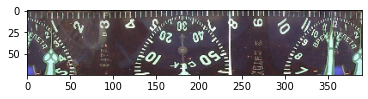

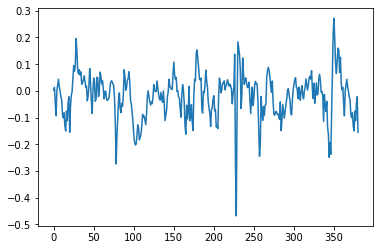

233.0


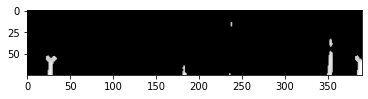

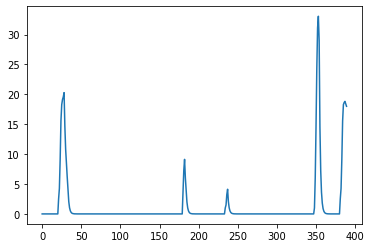

[(28, 20.28515625, 6), (353, 33.0625, 6), (387, 18.820312503379682, 6)]
0:58:38


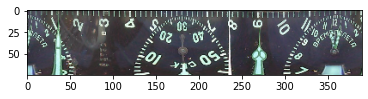

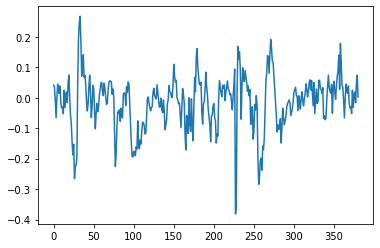

232.0


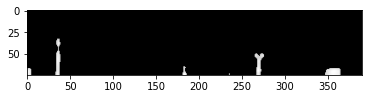

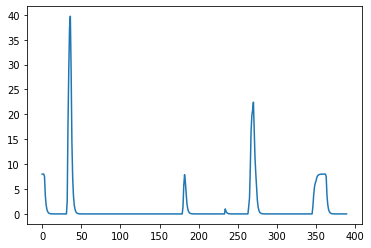

[(36, 39.718750000873115, 6), (270, 22.445312500014552, 5)]
9:6:38


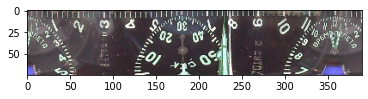

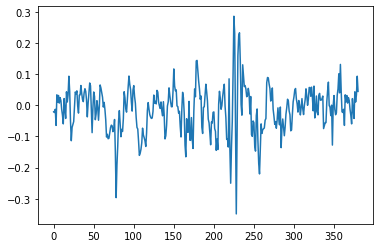

233.0


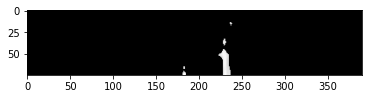

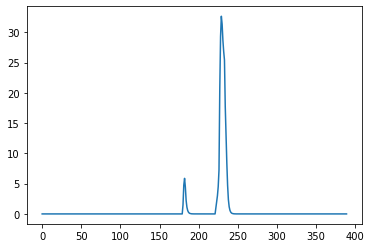

[(229, 32.656250000000064, 9)]
7:38:38


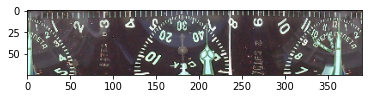

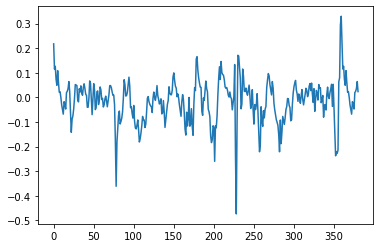

233.0


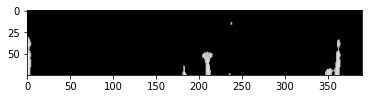

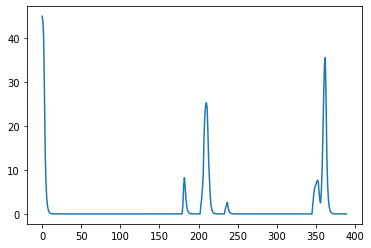

[(0, 45, 5), (210, 25.304687549360096, 6), (362, 35.570953369140625, 6)]
7:0:38


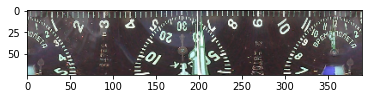

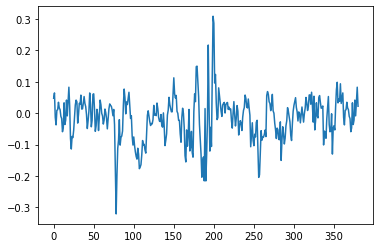

83.0


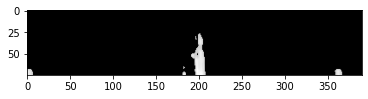

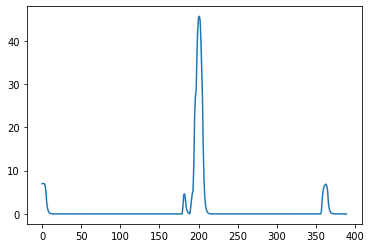

[(201, 45.661391496658325, 12)]
6:33:13


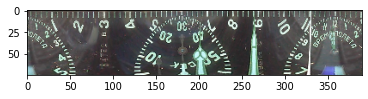

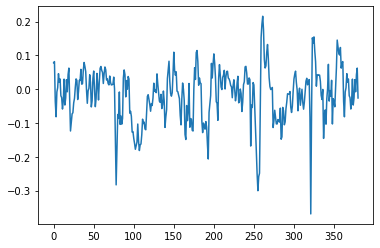

326.0


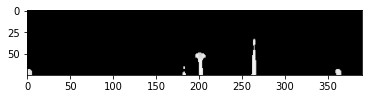

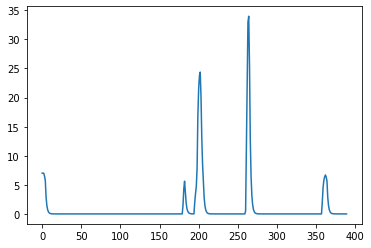

[(202, 24.367194771766663, 6), (264, 33.96875, 5)]
6:44:54


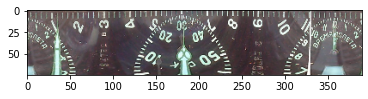

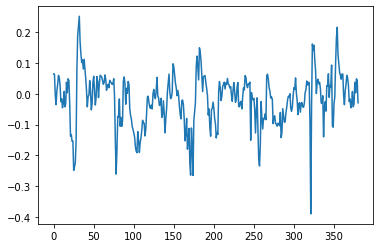

326.0


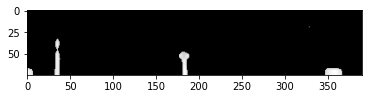

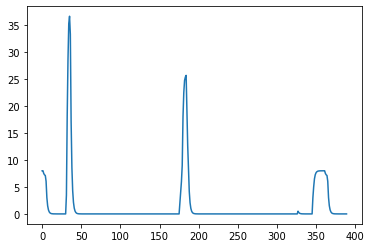

[(35, 36.65625000564614, 6), (184, 25.6875, 7)]
6:5:54


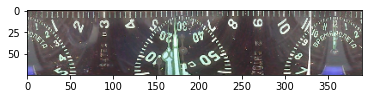

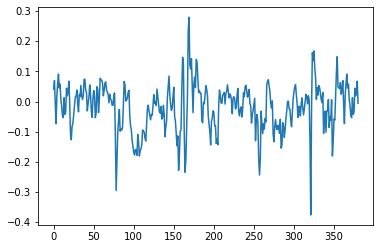

326.0


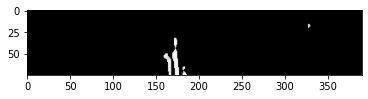

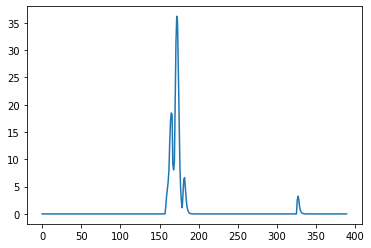

[(165, 18.48828125, 4), (172, 36.191314697265625, 6)]
5:28:54


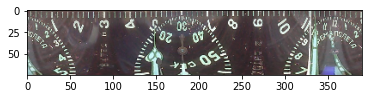

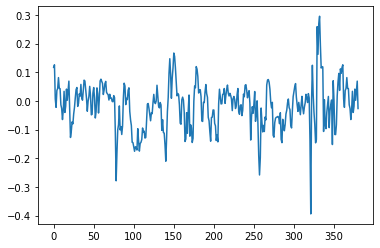

326.0


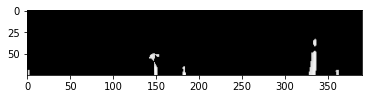

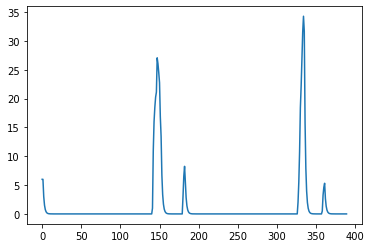

[(147, 27.0625, 10), (334, 34.2734375, 7)]
4:55:54


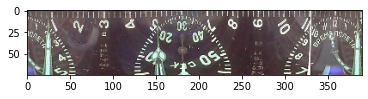

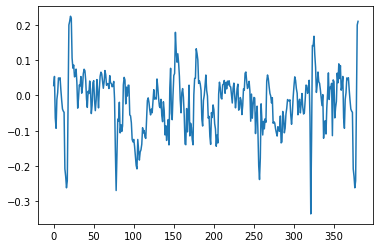

326.0


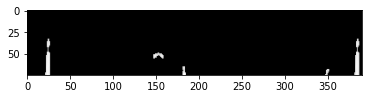

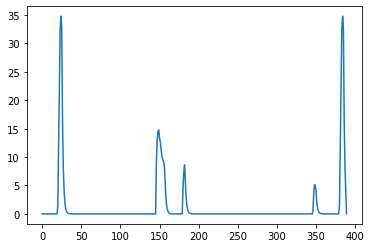

[(24, 34.78125, 6), (149, 14.75, 5), (384, 34.78125000023465, 6)]
4:4:54


In [58]:
for im in rotated:
    plt.imshow(im, cmap='gray'), plt.show()
    
    s = find_second_hand(im, templates[3])
    print(s)
    dis = s + 176
    
    f_im, graph = convert_image_to_graph(im)
    
    summer = 1
    for i in range(len(graph)):
        i %= 360
        
        if (dis - 15) % 360 <= i <= (dis + 15) % 360:
            if graph[i] > 2:
                graph[i] += summer
            
            if i <= (dis % 360):
                summer += 1
            else:
                summer -= 1

    blur_graph(graph)

    #     plt.imshow(f_im, cmap='gray'), plt.show()
#     plt.imshow(im, cmap='gray'), plt.show()
    plt.plot(graph), plt.show()
    
    key_points = []
    for x, y in enumerate(graph):
        if y > 12:
            key_points.append((x, y))
            
    groups = groups_points(key_points)
    filtred_groups = sum_group_values(groups)
    filtred_groups = remove_useless_groups(filtred_groups)
    
#     filtred_groups = sorted(filtred_groups, key=lambda p: p[1], reverse=True)
    print(filtred_groups)
    
    if len(filtred_groups) >= 2:
        m = max(filtred_groups, key=lambda p: p[1])[0]
        h = min(filtred_groups, key=lambda p: p[1])[0]
    else:
        m = max(filtred_groups, key=lambda p: p[1])[0]
        h = m
    
    h %= 360
    m %= 360
        
    h = (h * 12) // config.DEFAULT_WRAP_POLAR_WIDTH
    m = (m * 60) // config.DEFAULT_WRAP_POLAR_WIDTH
    s = (s * 60) // config.DEFAULT_WRAP_POLAR_WIDTH
    
    print(f'{int(h)}:{round(m)}:{round(s)}')